In [1]:
import os, sys
ROOT = os.path.abspath("..")
sys.path.append(os.path.join(ROOT, "src"))
import numpy as np
import yaml
from gym_env.ref_env import Ref, make_env
from helpers import helper as h
from helpers import device as d

import gymnasium as gym

# import stablebaselines
from stable_baselines3 import PPO, SAC, DDPG, TD3, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from wandb.integration.sb3 import WandbCallback
import gymnasium as gym

import matplotlib.pyplot as plt
from collections import Counter


In [122]:
env_name = "C1_94"
algo = "PPO"
model_name = "C1_94_H3_run_4"
timesteps = 4000000
mode = "models"

In [123]:
C_path = f'env_config/discrete_joint/{env_name}.yaml'  # Default path for environment configuration
with open(f"{ROOT}/{C_path}", 'r') as f:
        env_cfg = yaml.load(f, Loader=yaml.SafeLoader)

env_params = env_cfg.copy()
project_name = env_params['env']['name']
delta_t = env_params['env']['time_step']          # Time step in hours
total_t = env_params['env']['Total_time']          # Total simulation time in hours
timelimit = int(np.ceil(total_t / delta_t))

In [143]:
#data = np.load(f"{ROOT}/results/{project_name}/{env_name}/test_data/RL/{model_name}/{mode}/trajectories_5.npz")
data = np.load(f"{ROOT}/results/{project_name}/{env_name}/test_data/couple/trajectories_2.npz")
#datab = np.load(f"{ROOT}/results/{project_name}/{env_name}/test_data/bang_bang/trajectories_0.npz")

In [7]:
Q_max = data['Q_max']
print(f"Q_max: {Q_max[0,0,0,1]}")

Q_max: 466666.65625


In [144]:
Q_dist1 = data['Q_dist']
T_room1 = data['room_temps']
On_off1 = data['on_off']
Q_evap1 = data['Q_evap']
Power1 = data['W']
reward1 = data['total_cost']
Comp_cost1 = data['compressor_cost']

(array([34453., 34731., 34400., 34911., 34683., 34726., 34231., 34539.,
        34387., 34752., 34682., 34649., 34689., 34584., 34385., 34514.,
        34681., 34539., 34964., 34460., 34630., 34525., 34634., 34808.,
        34480., 34851., 34683., 34618., 34671., 34407., 34409., 34432.,
        34292., 35130., 34470., 34776., 34636., 34524., 34616., 34150.,
        34709., 34492., 34432., 34719., 34506., 34741., 34619., 34630.,
        34077., 34573.]),
 array([     0.      ,   4659.999375,   9319.99875 ,  13979.998125,
         18639.9975  ,  23299.996875,  27959.99625 ,  32619.995625,
         37279.995   ,  41939.994375,  46599.99375 ,  51259.993125,
         55919.9925  ,  60579.991875,  65239.99125 ,  69899.990625,
         74559.99    ,  79219.989375,  83879.98875 ,  88539.988125,
         93199.9875  ,  97859.986875, 102519.98625 , 107179.985625,
        111839.985   , 116499.984375, 121159.98375 , 125819.983125,
        130479.9825  , 135139.981875, 139799.98125 , 144459.980625

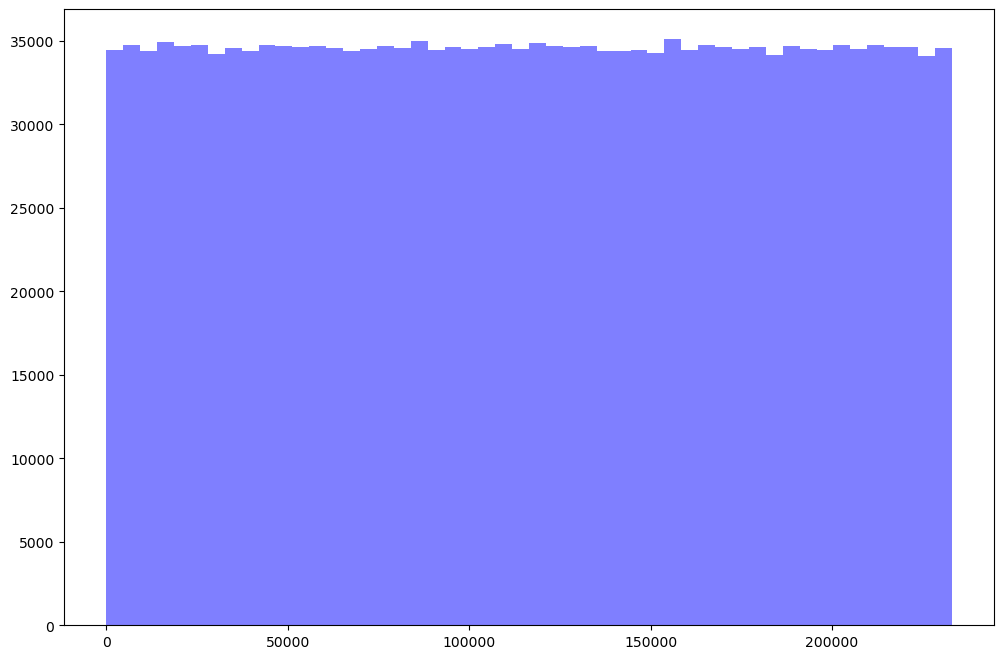

In [9]:
plt.figure(figsize=(12, 8))
plt.hist(Q_dist1.flatten(), bins=50, alpha=0.5, label='Q_dist', color='blue')

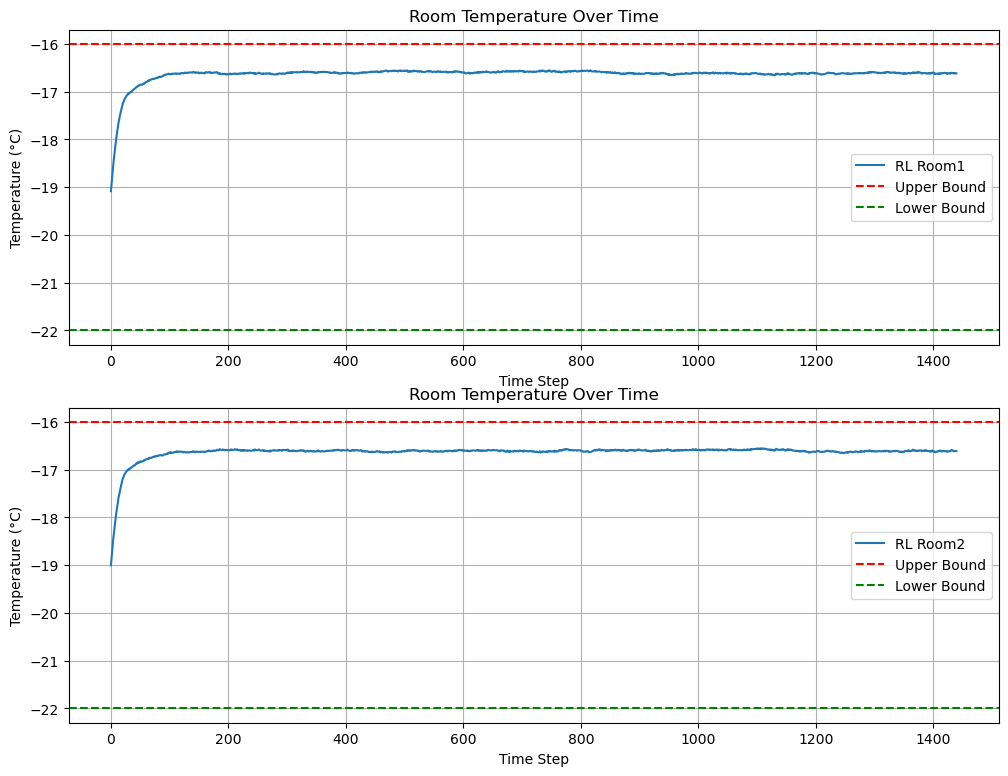

In [16]:
T = 1440
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.plot(np.mean(T_room1[:,:,0,:T], axis=(0,1)), label='RL Room1')
plt.axhline(-16, color='r', linestyle='--', label='Upper Bound')
plt.axhline(-22, color='g', linestyle='--', label='Lower Bound')

plt.title('Room Temperature Over Time')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()  
plt.subplot(2, 1, 2)
plt.plot(np.mean(T_room1[:,:,1,:T], axis=(0,1)), label='RL Room2')
plt.axhline(-16, color='r', linestyle='--', label='Upper Bound')
plt.axhline(-22, color='g', linestyle='--', label='Lower Bound')

plt.title('Room Temperature Over Time')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()  

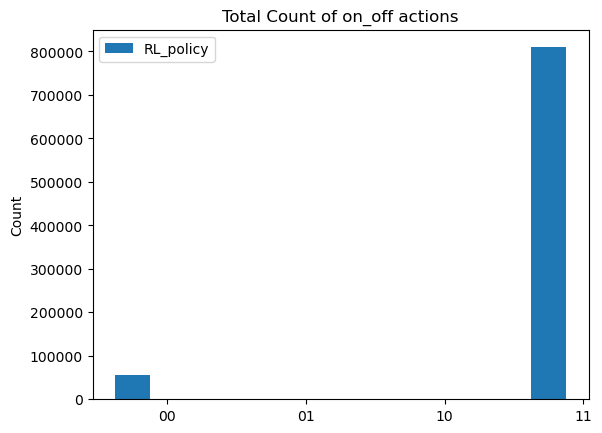

In [129]:
on_off = data['on_off']  # shape (T, num_evaps)


labels = ['00','01', '10','11']
l = np.arange(len(labels))
w = 0.25  # width of the bars

on_off_values = on_off[: , : , 0 , : ] * 2 + on_off[: , : , 1 , : ] * 1  # shape (T, num_evaps)

on_off_values = on_off_values.astype(int)

on_off_values = on_off_values.flatten()


counts_on_off = np.bincount(on_off_values, minlength=4)[:4]


plt.figure()
plt.bar(l - w, counts_on_off, width=w, label='RL_policy')

plt.xticks(l, labels)
plt.ylabel('Count')
plt.title('Total Count of on_off actions')
plt.legend()
plt.show()

In [145]:
room1_rl = T_room1[:, :, 0, :].flatten()
room2_rl = T_room1[:, :, 1, :].flatten()

mask1_rl_high = (room1_rl > -16) 
mask1_rl_low = (room1_rl < -22)

print(f"RL_policy Room1 High Violations count: {np.sum(mask1_rl_high)}, Low Violations count: {np.sum(mask1_rl_low)}")

RL_policy Room1 High Violations count: 17, Low Violations count: 5
